<a href="https://colab.research.google.com/github/Johnalug99/Climate-change-Sentimental-Analysis/blob/main/climate_change_twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **DATA PREPROCESSING**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
file_path2 = "/content/drive/MyDrive/Colab Notebooks/mw8yd7z9wc-2/The Climate Change Twitter Dataset.csv"
df = pd.read_csv(file_path2, parse_dates=['created_at'])
df.head()


,created_at,id,lng,lat,topic,sentiment,stance,gender,temperature_avg,aggressiveness
0,2006-06-06 16:06:42+00:00,6132,NaN,NaN,Weather Extremes,-0.097180,neutral,female,NaN,aggressive
1,2006-07-23 21:52:30+00:00,13275,-73.949582,40.650104,Weather Extremes,0.575777,neutral,undefined,-1.114768,aggressive
2,2006-08-29 01:52:30+00:00,23160,NaN,NaN,Weather Extremes,0.500479,neutral,male,NaN,aggressive
3,2006-11-07 02:46:52+00:00,57868,NaN,NaN,Weather Extremes,0.032816,neutral,male,NaN,aggressive
4,2006-11-27 14:27:43+00:00,304553,NaN,NaN,Importance of Human Intervantion,-0.090428,neutral,male,NaN,aggressive


In [ ]:
# Basic info
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15789411 entries, 0 to 15789410
Data columns (total 10 columns):
 #   Column           Dtype              
---  ------           -----              
 0   created_at       datetime64[ns, UTC]
 1   id               int64              
 2   lng              float64            
 3   lat              float64            
 4   topic            object             
 5   sentiment        float64            
 6   stance           object             
 7   gender           object             
 8   temperature_avg  float64            
 9   aggressiveness   object             
dtypes: datetime64[ns, UTC](1), float64(4), int64(1), object(4)
memory usage: 1.2+ GB
None
                 id           lng           lat     sentiment  temperature_avg
count  1.578941e+07  5.307538e+06  5.307538e+06  1.578941e+07     5.307538e+06
mean   8.459853e+17 -4.639117e+01  3.408025e+01  2.536663e-03     1.245156e+00
std    3.113522e+17  7.523162e+01  2.229430e+01  4.37

In [ ]:

print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')

Number of rows: 15789411
Number of columns: 10


In [ ]:
# Check missing values
missing = df.isnull().sum()
print("Missing values:\n", missing)

Missing values:
 created_at                0
id                        0
lng                10481873
lat                10481873
topic                     0
sentiment                 0
stance                    0
gender                    0
temperature_avg    10481873
aggressiveness            0
dtype: int64


In [ ]:
# Handling missing values and filling up with measures of central tendency
df.temperature_avg.fillna(df.temperature_avg.mean(), inplace=True)
df.isnull().sum()


<ipython-input-6-475d8e54b750>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.temperature_avg.fillna(df.temperature_avg.mean(), inplace=True)


,0
created_at,0
id,0
lng,10481873
lat,10481873
topic,0
sentiment,0
stance,0
gender,0
temperature_avg,0
aggressiveness,0


In [ ]:
# Dropping irrelevant columns

df = df.drop(columns=["lng", "lat"])



In [ ]:
from scipy import stats

# Columns to consider for Z-score outlier detection
num_cols = ["temperature_avg"]  # Add more columns if needed

# Drop rows with NaNs in selected columns (or fill them if preferred)
df_clean = df[num_cols].dropna()

# Compute absolute Z-scores
z_scores = np.abs(stats.zscore(df_clean))

# Detect rows where any column has Z-score > 3
outlier_mask = (z_scores > 3).any(axis=1)
print(f"The Z-score detected {outlier_mask.sum()} outliers.")

# Compute mean and std for each column
means = df[num_cols].mean()
stds = df[num_cols].std()

# Define 3-sigma bounds
lower_bounds = means - 3 * stds
upper_bounds = means + 3 * stds

# Cap outliers at the 3-sigma boundary
for col in num_cols:
    df[col] = np.where(df[col] < lower_bounds[col], lower_bounds[col],
                np.where(df[col] > upper_bounds[col], upper_bounds[col], df[col]))

print("Outliers capped at the 3-sigma boundary.")


The Z-score detected 431803 outliers.
Outliers capped at the 3-sigma boundary.


# **DATA WRANGLING**

In [ ]:
df.aggressiveness.loc[df.aggressiveness.isin(['not ag'])] = 'not aggressive'
# changing the category of the data columns
df["created_at"]    = pd.to_datetime(df["created_at"], utc=True)
df["topic"] = df["topic"].astype("category")
df["stance"] = df["stance"].astype("category")
df["gender"] = df["gender"].astype("category")

<ipython-input-9-e48c6ba43519>:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.aggressiveness.loc[df.aggressiveness.isin(['not ag'])] = 'not aggressive'
<ipython-input-9-e48c6ba43519>:1: SettingWithCopyWarning: 
A value is trying to be s

In [ ]:
# Feature engineering
df['year'] = df['created_at'].dt.year
df['month'] = df['created_at'].dt.month
df['day'] = df['created_at'].dt.day
df['hour'] = df['created_at'].dt.hour



In [ ]:
# Data normalization & scaling
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()
df_standard_scaled = df.copy()
df_standard_scaled[num_cols] = scaler.fit_transform(df[num_cols])


In [ ]:
# Compute basic statistics
import pandas as pd

# Example: numerical climate columns
climate_cols = ["temperature_avg", "sentiment"]
# Compute basic statistics
climate_stats = df[climate_cols].agg(['mean', 'median', 'std', 'min', 'max', 'skew', 'kurt'])

# Transpose for readability
climate_stats = climate_stats.T
climate_stats.columns = ['Mean', 'Median', 'Std Dev', 'Min', 'Max', 'Skewness', 'Kurtosis']

# Round values for clarity
climate_stats = climate_stats.round(3)

# Display the statistics
print("Basic Statistics for Climate Parameters:")
print(climate_stats)


Basic Statistics for Climate Parameters:
                  Mean  Median  Std Dev    Min    Max  Skewness  Kurtosis
temperature_avg  1.265   1.245    1.963 -5.364  7.854     0.079     4.050
sentiment        0.003  -0.002    0.438 -0.994  0.992     0.056    -1.185


# **DESCRIPTIVE ANALYSIS**

In [ ]:
df = df.sample(n=100000, random_state=42)

df.head()

,created_at,id,topic,sentiment,stance,gender,temperature_avg,aggressiveness,year,month,day,hour
10872768,2018-08-26 00:14:23+00:00,1033507918119723011,Politics,-0.609906,believer,male,1.245156,not aggressive,2018,8,26,0
467455,2009-12-10 07:02:43+00:00,6524579662,Importance of Human Intervantion,-0.362098,believer,male,1.245156,not aggressive,2009,12,10,7
12104298,2018-10-20 15:51:25+00:00,1053675061125832705,Weather Extremes,0.619185,neutral,female,7.854281,not aggressive,2018,10,20,15
5704154,2017-10-23 04:37:17+00:00,922321001639219205,Global stance,-0.324143,denier,undefined,1.245156,not aggressive,2017,10,23,4
15756396,2019-08-29 18:50:24+00:00,1167147506108702720,Politics,-0.509494,neutral,male,-0.253633,not aggressive,2019,8,29,18


Due to the largeness of the Dataset and to ensure seamless operations, a random sample of 100,000 was selected as a representative of the whole. This method has been applied since Big Data tools as Dask, Apache Spark has not been employed.

**EXPLORATORY DATA ANALYSIS**

In [ ]:
print(df[['temperature_avg', 'sentiment']].describe())

       temperature_avg      sentiment
count    100000.000000  100000.000000
mean          1.264274       0.001473
std           1.963955       0.438053
min          -5.363970      -0.969956
25%           1.245156      -0.396311
50%           1.245156      -0.004671
75%           1.245156       0.415837
max           7.854281       0.973560


In [ ]:
# Frequency count for categorical columns
print(df['topic'].value_counts())
print(df['stance'].value_counts())
print(df['aggressiveness'].value_counts())


topic
Global stance                                 26277
Importance of Human Intervantion              16452
Weather Extremes                              15626
Politics                                      11424
Undefined / One Word Hashtags                  8269
Donald Trump versus Science                    6302
Seriousness of Gas Emissions                   5741
Ideological Positions on Global Warming        3751
Impact of Resource Overconsumption             3097
Significance of Pollution Awareness Events     3061
Name: count, dtype: int64
stance
believer    71588
neutral     20741
denier       7671
Name: count, dtype: int64
aggressiveness
not aggressive    71229
aggressive        28771
Name: count, dtype: int64


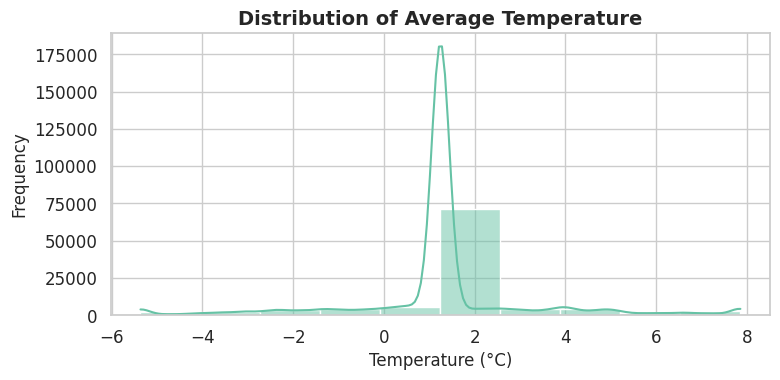

In [ ]:
# Setting a clean theme
sns.set(style="whitegrid", palette="pastel", font_scale=1.1)
plt.rcParams['figure.figsize'] = (8, 4)  # Set default figure size

# Histogram of temperature
sns.histplot(df['temperature_avg'], bins=10, kde=True, color="#66c2a5")
plt.title('Distribution of Average Temperature', fontsize=14, weight='bold')
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()


<ipython-input-17-c1ff5efcdac8>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='topic', data=df, order=df['topic'].value_counts().index,


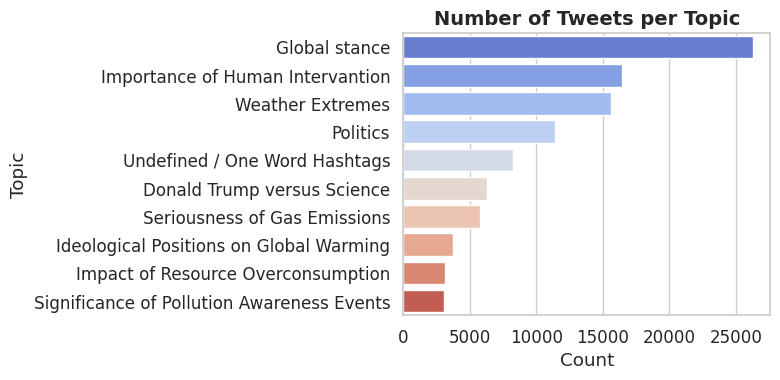

In [ ]:
sns.countplot(y='topic', data=df, order=df['topic'].value_counts().index,
              palette="coolwarm")
plt.title('Number of Tweets per Topic', fontsize=14, weight='bold')
plt.xlabel('Count')
plt.ylabel('Topic')
plt.tight_layout()
plt.show()




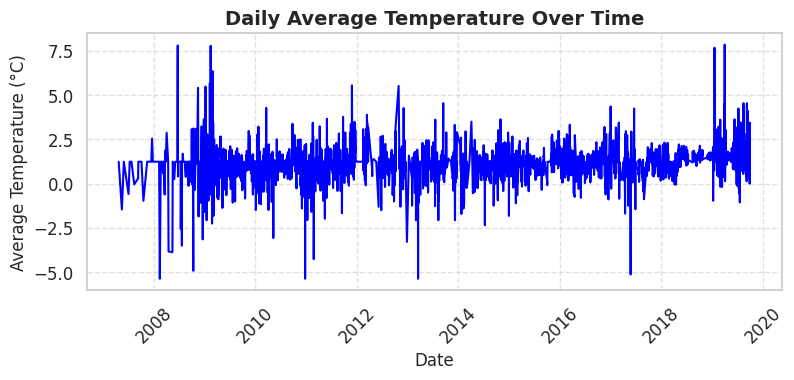

In [ ]:
df['date'] = pd.to_datetime(df['created_at']).dt.date
daily_avg_temp = df.groupby('date')['temperature_avg'].mean()

sns.lineplot(x=daily_avg_temp.index, y=daily_avg_temp.values, color="blue")
plt.title('Daily Average Temperature Over Time', fontsize=14, weight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Temperature (°C)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


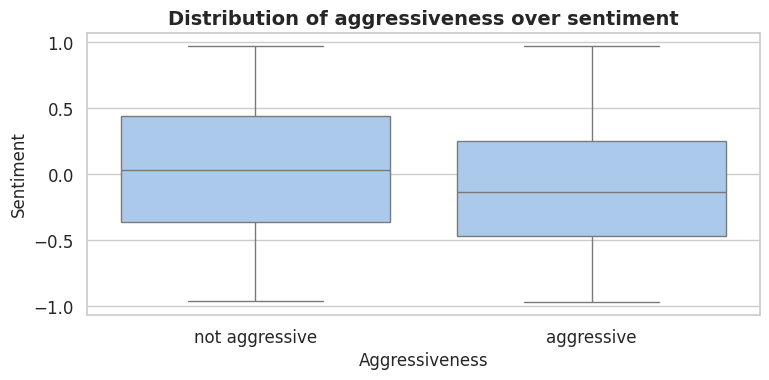

In [ ]:
#x Aggressiveness Distribution
sns.boxplot(data = df, y='sentiment', x='aggressiveness')
plt.title('Distribution of aggressiveness over sentiment', fontsize=14, weight='bold')
plt.xlabel('Aggressiveness', fontsize=12)
plt.ylabel('Sentiment', fontsize=12)
plt.tight_layout()
plt.show()

plt.show()

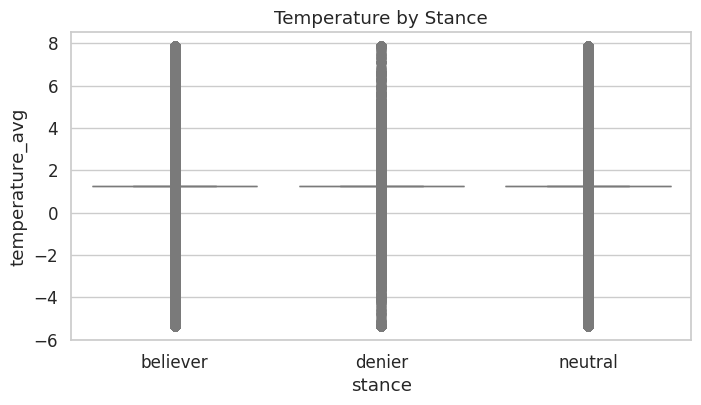

In [ ]:
# Boxplot by stance
sns.boxplot(x='stance', y='temperature_avg', data=df)
plt.title('Temperature by Stance')
plt.show()

<ipython-input-21-abba377f7ab3>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stance_counts.index, y=stance_counts.values, palette='pastel')


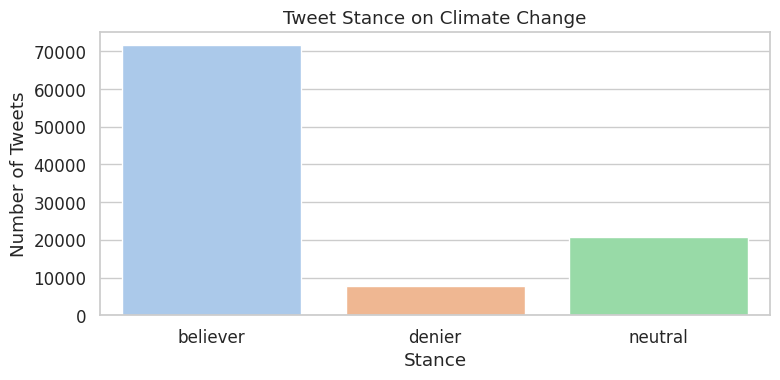

In [ ]:
# Tweets stance on climate change
stance_counts = df['stance'].value_counts()
sns.barplot(x=stance_counts.index, y=stance_counts.values, palette='pastel')
plt.title('Tweet Stance on Climate Change')
plt.xlabel('Stance')
plt.ylabel('Number of Tweets')
plt.tight_layout()
plt.show()


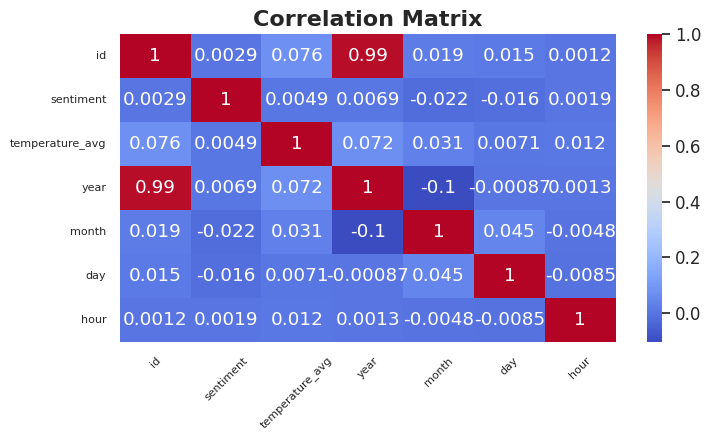

In [ ]:
# Select only numeric columns for the correlation matrix
numeric_df = df.select_dtypes(include=np.number)

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.xticks(rotation=45, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.show()

# **DIAGNOSTIC ANALYTICS**

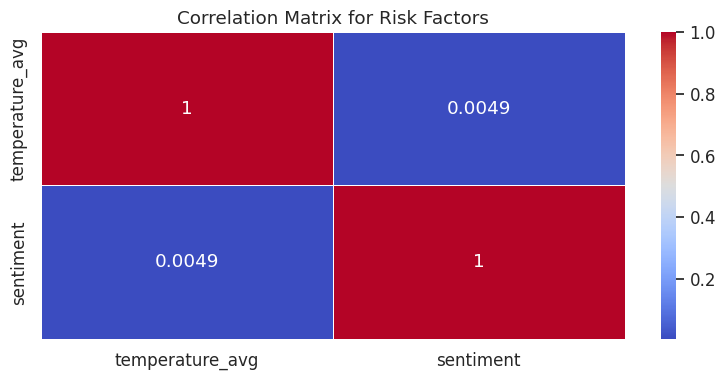

In [ ]:
# Correlation matrix
# Removing 'aggressiveness' as it is a categorical column with string values
corr_df = df[['temperature_avg', 'sentiment']].corr()

# Create a heatmap
sns.heatmap(corr_df, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix for Risk Factors')
plt.tight_layout()
plt.show()

**KEY INSIGHTS ON THE CORRELATION MATRIX ON TEMPERATURE, SENTIMENT AND AGGRESSIVENESS**

**temperature_avg & sentiment** has a coefficient of **0.0049** This value is very close to zero, meaning there is virtually no linear relationship between average temperature and sentiment in the tweets.In simple terms: as temperature changes, it doesn't cause any consistent change in sentiment — they behave independently.



In [ ]:
# Sort by date
df = df.sort_values('date')

# Optional: Resample monthly if data is daily
# df_monthly = df.set_index('date').resample('M').mean().reset_index()

# Using raw daily or monthly values
df['temp_rolling_mean'] = df['temperature_avg'].rolling(window=7).mean()
df['temp_rolling_std'] = df['temperature_avg'].rolling(window=7).std()

# Z-score based anomaly detection
df['temp_z_score'] = (df['temperature_avg'] - df['temp_rolling_mean']) / df['temp_rolling_std']
df['is_anomaly'] = df['temp_z_score'].abs() > 2.5  # You can tune the threshold

# Print anomalies
anomalies = df[df['is_anomaly']]
print(f"Detected {len(anomalies)} temperature anomalies.")


Detected 0 temperature anomalies.


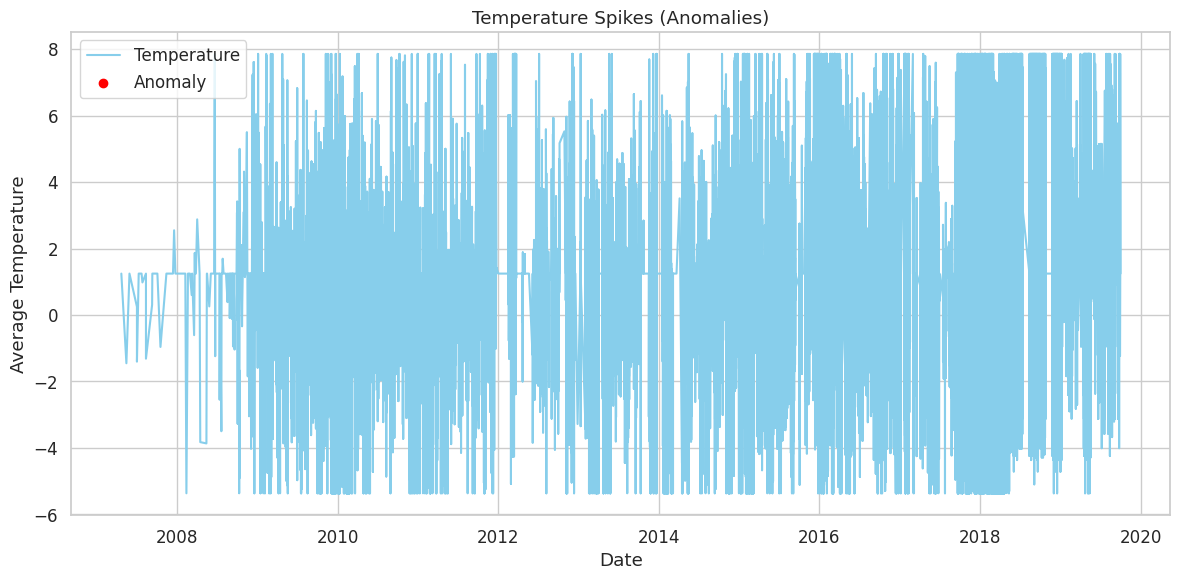

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['temperature_avg'], label='Temperature', color='skyblue')
plt.scatter(anomalies['date'], anomalies['temperature_avg'], color='red', label='Anomaly')
plt.title('Temperature Spikes (Anomalies)')
plt.xlabel('Date')
plt.ylabel('Average Temperature')
plt.legend()
plt.tight_layout()
plt.show()


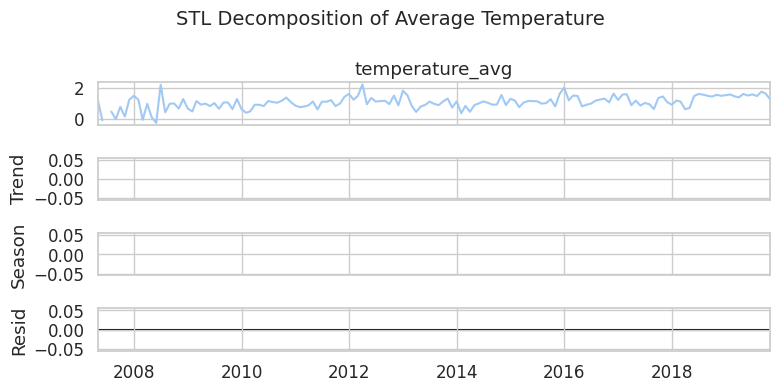

In [ ]:
# Trend analysis: checking shifts in clmate patterns
!pip install statsmodels
from statsmodels.tsa.seasonal import STL

# Ensure datetime and set index
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Select only numeric columns before resampling and aggregation
df_monthly = df.set_index('date').select_dtypes(include=np.number).resample('ME').mean()

# Apply STL to average temperature
# Check if 'temperature_avg' is present after resampling (it should be if it was numeric)
if 'temperature_avg' in df_monthly.columns:
    stl = STL(df_monthly['temperature_avg'], period=12)  # monthly seasonality
    res = stl.fit()

    # Plot decomposition
    res.plot()
    plt.suptitle('STL Decomposition of Average Temperature', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("Error: 'temperature_avg' column not found in the resampled monthly data. Check numerical columns selection.")

# **PREDICTIVE ANALYSIS**

In [ ]:
# Feature engineering
# Ensure date column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Grouping by date to get daily average temperature
daily_temp = df.groupby(df['date'].dt.date)['temperature_avg'].mean().reset_index()
daily_temp.rename(columns={'date': 'day', 'temperature_avg': 'avg_temp'}, inplace=True)

# Convert 'day' back to datetime (to avoid string format)
daily_temp['day'] = pd.to_datetime(daily_temp['day'])


In [ ]:
# Linear regression model
from sklearn.linear_model import LinearRegression
import numpy as np

# Convert dates to numerical format
daily_temp['day_ordinal'] = daily_temp['day'].map(lambda x: x.toordinal())

# Prepare data
X = daily_temp[['day_ordinal']]
y = daily_temp['avg_temp']

#Split into training and test sets (e.g., 80% train, 20% test)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # no shuffle for time series


In [ ]:
from sklearn.linear_model import LinearRegression

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on both train and test sets
y_pred = model.predict(X_test)



In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score, classification_report, accuracy_score

print("MAE:", mean_absolute_error(y_test, y_pred))
print("Test R²:", r2_score(y_test, y_pred))

MAE: 0.5097254045946922
Test R²: -0.036927399910218206


In [ ]:
# Clustering: Grouping similar trends
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Select relevant features
features = ['sentiment', 'temperature_avg', 'topic']
df_cluster = df[features].dropna()

# One-hot encode the topic column
df_cluster = pd.get_dummies(df_cluster, columns=['topic'], drop_first=True)

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)


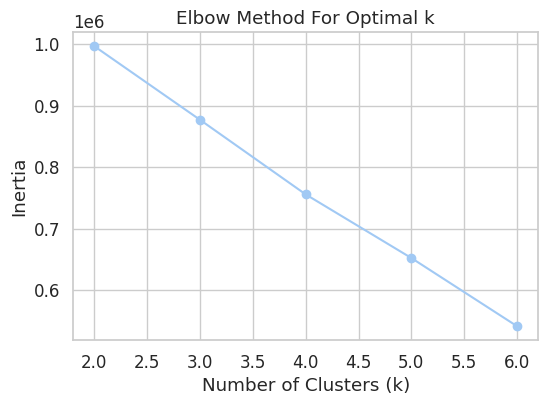

In [ ]:
# Find the best number of clusters using the Elbow method
inertia = []
k_range = range(2, 7)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

# Plot the elbow curve
plt.figure(figsize=(6, 4))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()


In [ ]:
# Fit KMeans with chosen k
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels back to the original DataFrame
df_cluster['cluster'] = clusters


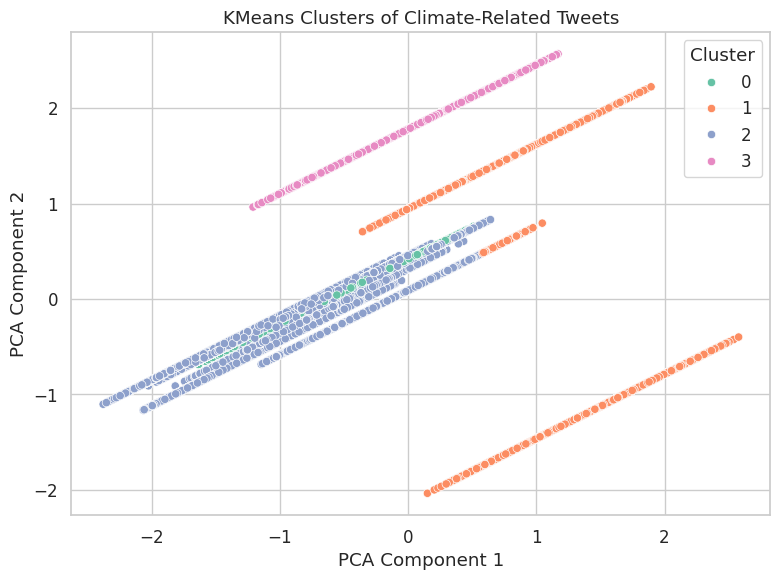

In [ ]:
# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_cluster['pca_1'] = X_pca[:, 0]
df_cluster['pca_2'] = X_pca[:, 1]

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_cluster, x='pca_1', y='pca_2', hue='cluster', palette='Set2')
plt.title('KMeans Clusters of Climate-Related Tweets')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# Target column
target = 'stance'

# Feature columns
numerical_features = ['sentiment', 'temperature_avg']
categorical_features = ['gender', 'aggressiveness']

label_encoder = LabelEncoder()
df['stance_encoded'] = label_encoder.fit_transform(df['stance'])



In [ ]:
# Preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)


In [ ]:
X = df[numerical_features + categorical_features]
y = df['stance_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Fit-transform training data and transform test data
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)


**RANDOM FOREST REGRESSION**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(X_train_processed, y_train)
y_pred_rf = rf_model.predict(X_test_processed)

print("Model: Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))


Model: Random Forest
Accuracy: 0.6563
              precision    recall  f1-score   support

    believer       0.75      0.82      0.78     14268
      denier       0.18      0.14      0.16      1510
     neutral       0.37      0.30      0.33      4222

    accuracy                           0.66     20000
   macro avg       0.44      0.42      0.43     20000
weighted avg       0.63      0.66      0.64     20000



**K-NEAREST NEIGHBORS**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
knn_model.fit(X_train_processed, y_train)
# Use the processed test data for prediction
y_pred_knn = knn_model.predict(X_test_processed)

print("Model: K-Nearest Neighbors")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn, target_names=label_encoder.classes_))

Model: K-Nearest Neighbors
Accuracy: 0.69975
              precision    recall  f1-score   support

    believer       0.74      0.92      0.82     14268
      denier       0.26      0.07      0.11      1510
     neutral       0.42      0.18      0.25      4222

    accuracy                           0.70     20000
   macro avg       0.47      0.39      0.39     20000
weighted avg       0.64      0.70      0.65     20000



**NAIVES BAYES**

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report # Import necessary metrics

nb_model = GaussianNB()
nb_model.fit(X_train_processed, y_train)
# Use the processed test data for prediction
y_pred_nb = nb_model.predict(X_test_processed) # Corrected: Use X_test_processed

print("Model: Naive Bayes")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb, target_names=label_encoder.classes_))

Model: Naive Bayes
Accuracy: 0.6931
              precision    recall  f1-score   support

    believer       0.72      0.95      0.82     14268
      denier       0.18      0.04      0.07      1510
     neutral       0.32      0.06      0.09      4222

    accuracy                           0.69     20000
   macro avg       0.40      0.35      0.33     20000
weighted avg       0.59      0.69      0.61     20000

